# 2D Image Processing

Based on [this workshop](https://github.com/CameraIA/dipmicroct/blob/master/partI/01_2d_processing.ipynb).

### Environment setup

In [1]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
# Display and store images in this notebook
%matplotlib inline

In [3]:
# Import functions to ease plotting images
import supplementary_code as sc

In [4]:
# Set font family for plots
plt.rcParams['font.family'] = 'monospace'

## Reading and displaying images
Uses [cells.tif](https://github.com/CameraIA/dipmicroct/blob/master/data/cells.tif).

In [5]:
# Import library to read and display images
import skimage.io

Read the data file

In [6]:
# Read data file
cells = skimage.io.imread("cells.tif")

Examine the data using shape, type, and range

In [7]:
print('* "cells" shape: {}'.format(cells.shape))
print('* "cells" type: {}'.format(cells.dtype))
print('* "cells" range: {}, {}'.format(cells.min(), cells.max()))

* "cells" shape: (60, 256, 256)
* "cells" type: float64
* "cells" range: 0.0, 1.0


The range between 0.0 and 1.0 tells us that the images are grayscale. Grayscale images also only have two dimensions, so we know that we are looking at 60 different images in the `cell` variable. The type is `float64`, but `matplotlib` prefers `float32`, so we may need to keep that in mind for plotting. It typically won't be an issue though if we explicitly set the colormap to `gray`, as shown below when displaying the 33rd image in the set.

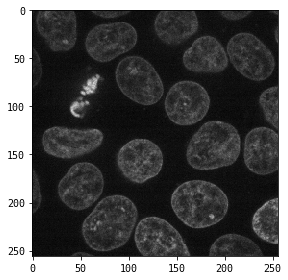

In [8]:
plane = cells[32]
skimage.io.imshow(plane, cmap='gray')

_Note:_ `skimage.io.imshow` can only display 2D images

## Evaluating or changing exposure

The `skimage.exposure` module contains many functions for adjusting image contrast

In [9]:
import skimage.exposure

### Gamma correction

* The `skimage.exposure.adjust_gamma` function performs [gamma correction](https://en.wikipedia.org/wiki/Gamma_correction) on an image
* Gamma correction adjusts the shadows of an image
* $\gamma < 1$ makes shadows lighter while $\gamma > 1$ makes shadows darker

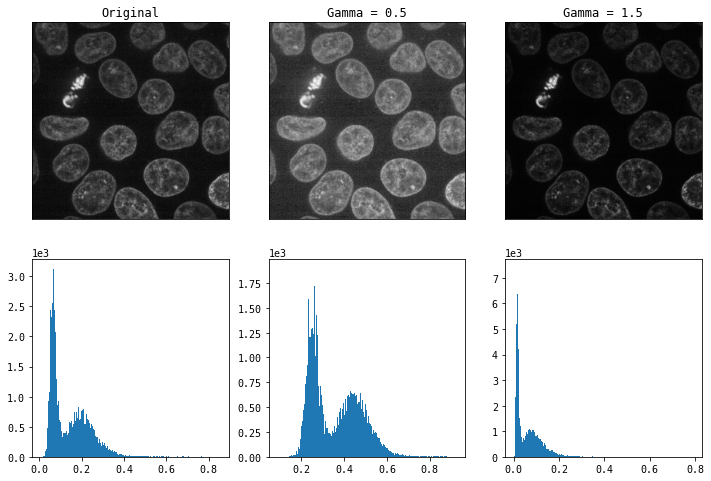

In [10]:
## Apply different gamma corrections and plot to compare

# Set low and high gamma values
gamma_val_low = 0.5
gamma_val_high = 1.5

# Apply each gamma correction
plane_gamma_low = skimage.exposure.adjust_gamma(plane, gamma=gamma_val_low)
plane_gamma_high = skimage.exposure.adjust_gamma(plane, gamma=gamma_val_high)

# Get positions for subplots
_, ((win_top_left, win_top_center, win_top_right),
    (win_bottom_left, win_bottom_center, win_bottom_right)) = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Plot original and its histogram
sc.show_plane(win_top_left, plane, title='Original')
sc.plot_hist(win_bottom_left, plane)

# Plot gamma = 0.5 and its histogram.
sc.show_plane(win_top_center, plane_gamma_low, title='Gamma = {}'.format(gamma_val_low))
sc.plot_hist(win_bottom_center, plane_gamma_low)

# Plot gamma = 1.5 and its histogram.
sc.show_plane(win_top_right, plane_gamma_high, title='Gamma = {}'.format(gamma_val_high))
sc.plot_hist(win_bottom_right, plane_gamma_high)

### Rescaling

* Many images have salt and pepper images
* Bright spots can decrease contrast
* Clipping the 0.5% brightest and darkest pixels can increase contrast
* This clipping can be done using `skimage.exposure.rescale_intensity`

_Note:_ The `skimage.exposure.rescale_intensity` call below implicitly changes the image from `float64` to `float32`

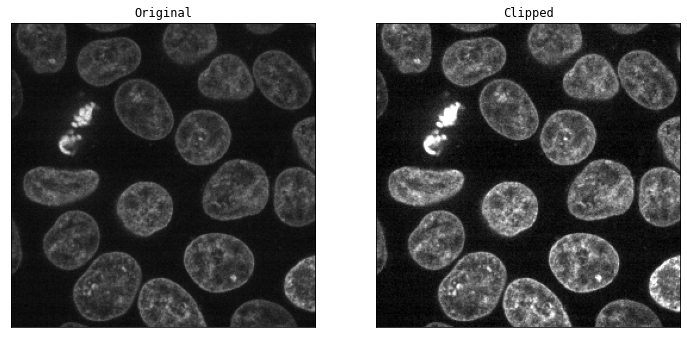

In [11]:
## Get the 0.5 and 99.5 percentile values for the image then rescale the image and display

# Get percentiles
vmin, vmax = np.percentile(plane, q=(0.5,99.5))

# Rescale image
plane_clipped = skimage.exposure.rescale_intensity(plane, in_range=(vmin,vmax), out_range=np.float32)

# Display original and clipped for comparison
_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

sc.show_plane(win_left, plane, title='Original');
sc.show_plane(win_right, plane_clipped, title='Clipped');

The tutorial now changes the variable name from `plane_clipped` to `plane_rescaled`. The rescaled image is used for further processing through the rest of the workshop.

In [12]:
# Rename
plane_rescaled = plane_clipped

### Processing histograms 

* Histograms are often used for evaluating exposure
* [Histogram equalization](https://en.wikipedia.org/wiki/Histogram_equalization) improves global contrast by redistributing pixel intensities
* This method can lead to enhancing background noise since the redistribution is indiscriminate
* Histogram equalization can be performed using `skimage.exposure.equalize_hist`
* [Adaptive histogram equalization](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization) performs histogram equalization on many different isolated regions, so it is good at improving local contrast
* This method can overamplify noise in relatively homogeneous regions
* Contrast limited adaptive histogram equalization (CLAHE) solves this by limiting amplification
* CLAHE can be performed using `skimage.exposure.equalize_adapthist`

#### Exercise

Process the histogram of `plane` using both `skimage.exposure.equalize_hist` and `skimage.exposure.equalize_adapthist` and visualize.

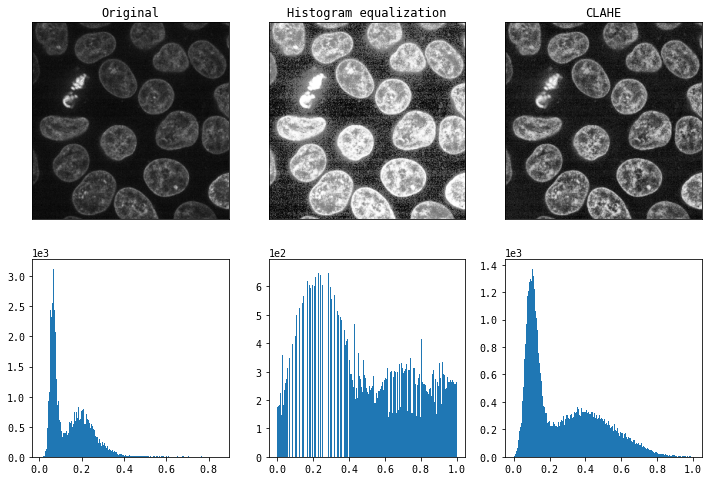

In [13]:
# Process using histogram equalization
plane_equalized = skimage.exposure.equalize_hist(plane)

# Process using adaptive histogram equalization
plane_clahe = skimage.exposure.equalize_adapthist(plane)

## Display resulting images and their histograms
# Get positions for subplots
_, ((win_top_left, win_top_center, win_top_right),
    (win_bottom_left, win_bottom_center, win_bottom_right)) = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Display images
sc.show_plane(win_top_left, plane, title='Original');
sc.show_plane(win_top_center, plane_equalized, title='Histogram equalization');
sc.show_plane(win_top_right, plane_clahe, title='CLAHE');

# Display histograms
sc.plot_hist(win_bottom_left, plane)
sc.plot_hist(win_bottom_center, plane_equalized)
sc.plot_hist(win_bottom_right, plane_clahe)

## Applying filters

[`skimage.filters`](https://scikit-image.org/docs/stable/api/skimage.filters.html) has functions that can be used for edge detection, filtering and thresholding
* [Threshholding](https://scikit-image.org/docs/stable/auto_examples/applications/plot_thresholding.html):
    * `filters.threshold_*` (multiple different functions with this prefix)
    * `filters.try_all_threshold` to compare various methods
* [Edge detection/enhancement](https://scikit-image.org/docs/stable/auto_examples/edges/plot_edge_filter.html):    
    * `filters.sobel` (not adapted for 3D images. It can be applied planewise to approximate a 3D result)
    * `filters.prewitt`
    * `filters.scharr`
    * `filters.roberts`
    * `filters.laplace`
    * `filters.hessian`
* [Ridge filters](https://scikit-image.org/docs/stable/auto_examples/edges/plot_ridge_filter.html#id6) (detect vessels, rivers, etc.):
    * `filters.meijering`
    * `filters.sato`
    * `filters.frangi`
* Inverse filtering (see also `skimage.restoration`):
    * `filters.weiner`
    * `filters.inverse`
* [Directional](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_gabor.html): `filters.gabor`
* Blurring/denoising:
    * `filters.gaussian`
    * `filters.median`
* [Sharpening](https://scikit-image.org/docs/stable/auto_examples/filters/plot_unsharp_mask.html): `filters.unsharp_mask`
* Define your own filter: `LPIFilter2D`
* Rank (nonlinear): `filters.rank` sub-module

In [14]:
import skimage.filters

### Edge detection

* Edge detection highlights areas where there is a steep change in contrast
* Intensity corresponds to steepness of curve
* The Sobel operator approximates the gradient of the image intensity and is fast

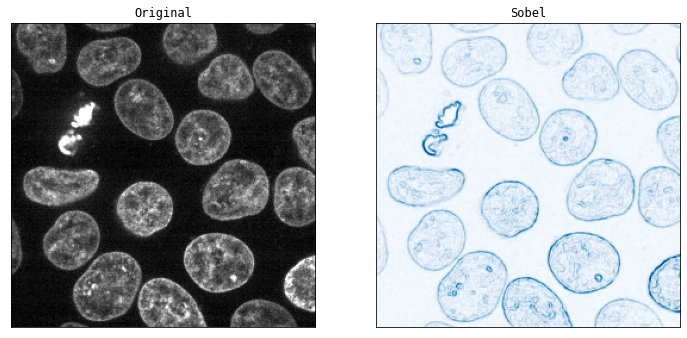

In [15]:
# Apply Sobel edge detection
plane_sobel = skimage.filters.sobel(plane_rescaled)

# Display results
_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

sc.show_plane(win_left, plane_rescaled, title='Original');
# setting a different map to ease visualization
sc.show_plane(win_right, plane_sobel, title='Sobel', cmap='Blues');

#### Exercise

Compare the results of `filters.sobel_h` (horizontal Sobel filter), `filters.sobel_v` (vertical Sobel filter), `filters.roberts`, `filters.prewitt`, and `filters.scharr`

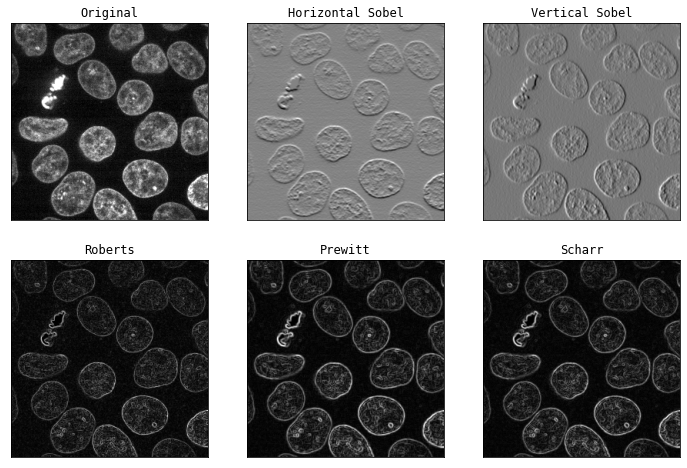

In [16]:
## Apply different filters and display results

# Apply filters
plane_sobel_h = skimage.filters.sobel_h(plane_rescaled)
plane_sobel_v = skimage.filters.sobel_v(plane_rescaled)
plane_roberts = skimage.filters.roberts(plane_rescaled)
plane_prewitt = skimage.filters.prewitt(plane_rescaled)
plane_scharr = skimage.filters.scharr(plane_rescaled)

# Get positions of subfigures
_, ((win_top_left, win_top_center, win_top_right),
    (win_bottom_left, win_bottom_center, win_bottom_right)) = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Plot
sc.show_plane(win_top_left, plane_rescaled, title='Original')
sc.show_plane(win_top_center, plane_sobel_h, title='Horizontal Sobel')
sc.show_plane(win_top_right, plane_sobel_v, title='Vertical Sobel')

sc.show_plane(win_bottom_left, plane_roberts, title='Roberts')
sc.show_plane(win_bottom_center, plane_prewitt, title='Prewitt')
sc.show_plane(win_bottom_right, plane_scharr, title='Scharr')

### Blurring/denoising

#### Gaussian

[Gaussian filter](https://en.wikipedia.org/wiki/Gaussian_filter) (`skimage.filters.gaussian`) blurs image by applying a weighted average of pixels in a kernel with the weight distributed by a Gaussian function with standard deviation `sigma`

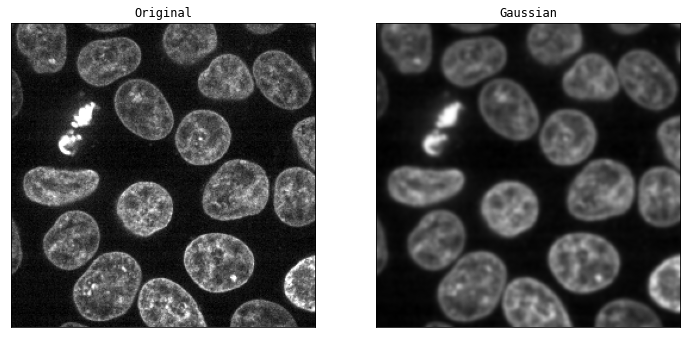

In [17]:
## Apply and display Gaussian filter

# Set sigma and apply Gaussian filter
sigma = 1.5

plane_gaussian = skimage.filters.gaussian(plane_rescaled, multichannel=False, sigma=sigma)

# Plot blurred vs original
_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

sc.show_plane(win_left, plane_rescaled, title='Original');
sc.show_plane(win_right, plane_gaussian, title='Gaussian');

#### Median

[Median filter](https://en.wikipedia.org/wiki/Median_filter):
* Removes noise
* Especially effective with salt and pepper noise 
* Preserves edges
* Is implemented with `skimage.filters.median` (doesn't' support 3D)

_Note:_ The use of `behavior='ndimage'` below causes the `skimage.filters.median` function to call `scipy.ndimage.median_filter`. The alternative is the old behavior of this function which is reproduced as a call to `skimage.filters.rank.median`.

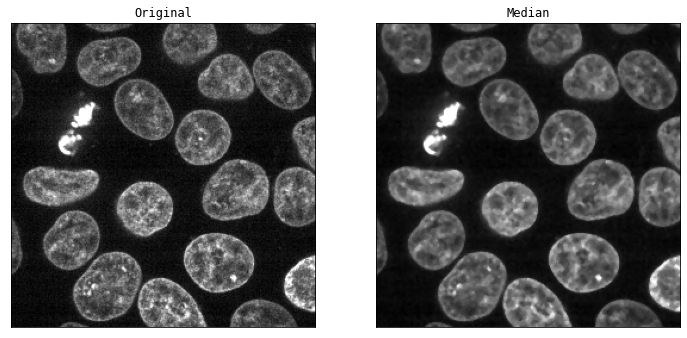

In [18]:
## Apply and display median filter

# Apply median filter
plane_median = skimage.filters.median(plane_rescaled, behavior='ndimage')

# Plot denoised vs original
_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

sc.show_plane(win_left, plane_rescaled, title='Original');
sc.show_plane(win_right, plane_median, title='Median');

The tutorial now changes the variable name from `plane_median` to `plane_denoised`. The denoised image is used for further processing through the rest of the workshop.

In [19]:
# Rename
plane_denoised = plane_median

#### Restoration

The [`skimage.restoration`](https://scikit-image.org/docs/dev/api/skimage.restoration.html) module has many functions to restore and denoise images.

In [20]:
import skimage.restoration

##### Exercise
 Apply bilateral (`restoration.denoise_bilateral`) and Chambolle's total variation (`restoration.denoise_tv_chambolle`) filters on `plane_rescaled`

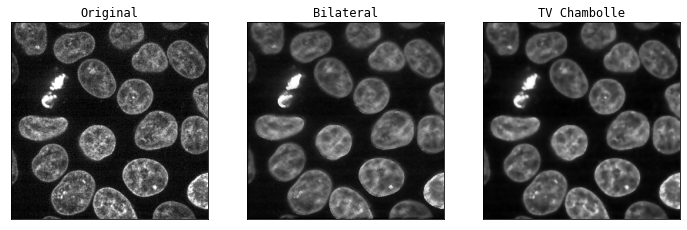

In [21]:
## Apply bilateral and Chambolle's total variation filters and display for comparison

# Apply filters
plane_bilateral = skimage.restoration.denoise_bilateral(plane_rescaled)
plane_chambolle = skimage.restoration.denoise_tv_chambolle(plane_rescaled)

# Checking the results.
_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))

sc.show_plane(win_left, plane_rescaled, title='Original')
sc.show_plane(win_center, plane_bilateral, title='Bilateral')
sc.show_plane(win_right, plane_chambolle, title='TV Chambolle')

### [Thresholding](https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29)

* Used to create binary images
* Threshold separates foreground from background
* Foreground are those brighter than threshold and background are those darker
* Form of image segmentation
* Different algorithms produce different results

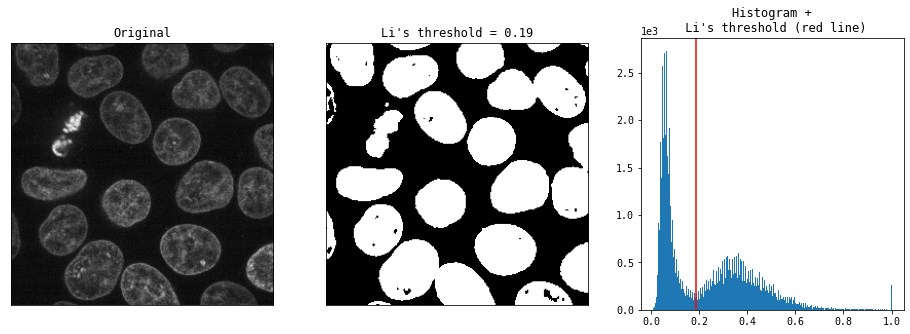

In [22]:
## Calculate threshold using Li's minimum cross entropy then display

# Calculate Li's threshold and create mask (binary image)
threshold_li = skimage.filters.threshold_li(plane_denoised)
plane_binary = plane_denoised >= threshold_li

# Get subplot positions
_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

# Display results
sc.show_plane(win_left, plane, title='Original')
sc.show_plane(win_center, plane_binary, title='Li\'s threshold = {:0.2}'.format(threshold_li))

sc.plot_hist(win_right, plane_denoised, 'Histogram +\n Li\'s threshold (red line)')
win_right.axvline(threshold_li, c='r')

#### Exercise

Try multiple thresholding algorithms and plot to compare

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


* ISODATA threshold: 0.2461949586868286
* Li threshold: 0.18851447105407715
* Mean threshold: 0.23105770349502563
* Minimum threshold: 0.18418529629707336
* Otsu threshold: 0.25007057189941406
* Triangle threshold: 0.14542925357818604
* Yen threshold: 0.4516019821166992


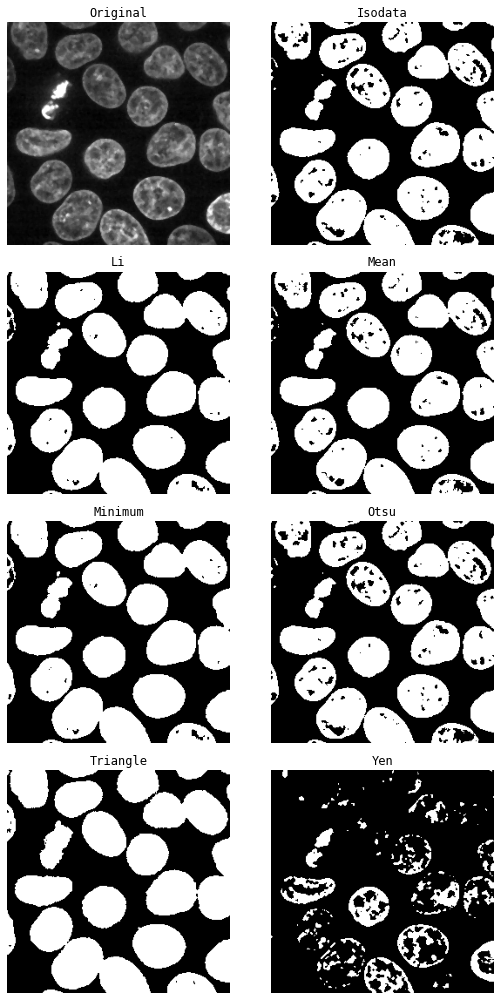

In [23]:
skimage.filters.try_all_threshold(plane_denoised, figsize=(8, 14))

print('\n')
print('* ISODATA threshold: {}'.format(skimage.filters.threshold_isodata(plane_denoised)))  # This one is for free!
print('* Li threshold: {}'.format(skimage.filters.threshold_li(plane_denoised)))  # Li
print('* Mean threshold: {}'.format(skimage.filters.threshold_mean(plane_denoised)))  # Mean
print('* Minimum threshold: {}'.format(skimage.filters.threshold_minimum(plane_denoised)))  # Minimum
print('* Otsu threshold: {}'.format(skimage.filters.threshold_otsu(plane_denoised)))  # Otsu
print('* Triangle threshold: {}'.format(skimage.filters.threshold_triangle(plane_denoised)))  # Triangle
print('* Yen threshold: {}'.format(skimage.filters.threshold_yen(plane_denoised)))  # Yen

## Binary and grayscale morphology

* Morphological image processing is a collection of non-linear operations related to the shape or morphology of features in an image (e.g., boundaries, skeletons, etc.)
* Probe an image with a small shape or template called a structuring element
* Structuring element defines the region of interest or neighborhood around a pixel
* [Mathematical morphology](https://en.wikipedia.org/wiki/Mathematical_morphology) operations and structuring elements are defined in [`skimage.morphology`](https://scikit-image.org/docs/stable/api/skimage.morphology.html)
* Structuring elements are shapes which define areas over which an operation is applied
* Response to filter indicates how well the neighborhood corresponds to the structuring element's shape
* Not all 2D structuring element have a 3D counterpart
* Simplest and most commonly used structuring elements are the disk/ball and square/cube

In [24]:
import skimage.morphology

In [25]:
# Examine 2D disk and 3D ball
disk = skimage.morphology.disk(radius=5)
ball = skimage.morphology.ball(radius=5)
print('* "disk" shape: {}\n* "ball" shape: {}'.format(disk.shape, ball.shape))

* "disk" shape: (11, 11)
* "ball" shape: (11, 11, 11)


* Most basic mathematical morphology operations are `dilation` and `erosion`
* Dilation enlarges bright regions and shrinks dark regions
* Erosion shrinks bright regions and enlarges dark regions
* Other morphological operations are composed of dilation and erosion
* Closing of an image is defined as a dilation followed by an erosion
* Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks
* This tends to “close” up (dark) gaps between (bright) features
* Opening on an image is defined as an erosion followed by a dilation
* Opening can remove small bright spots (i.e. “salt”) and connect small dark cracks
* This tends to “open” up (dark) gaps between (bright) features.
* Opening and closing only work with 3D images and structuring elements
* 2D structuring element cannot be applied to a 3D image or vice versa
* Closing, dilation, erosion, opening have binary counterparts which are faster to compute than the grayscale algorithms

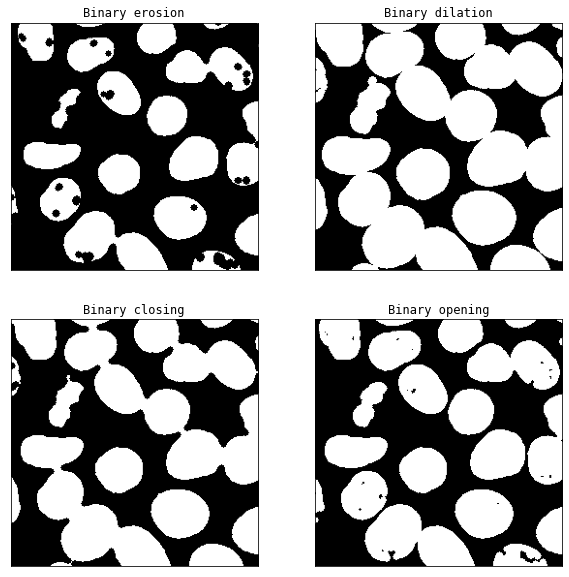

In [26]:
## Examine effects of erosion, dilation, closing and opening

# Set the probe shape
selem = skimage.morphology.disk(radius=3)

# Apply operations
plane_binary_closing = skimage.morphology.binary_closing(plane_binary, selem=selem)
plane_binary_dilation = skimage.morphology.binary_dilation(plane_binary, selem=selem)
plane_binary_erosion = skimage.morphology.binary_erosion(plane_binary, selem=selem)
plane_binary_opening = skimage.morphology.binary_opening(plane_binary, selem=selem)

# Get subplot positions
_, ((win_top_left, win_top_right),
    (win_bottom_left, win_bottom_right)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Plot results
sc.show_plane(win_top_left, plane_binary_erosion, title='Binary erosion')
sc.show_plane(win_top_right, plane_binary_dilation, title='Binary dilation')
sc.show_plane(win_bottom_left, plane_binary_closing, title='Binary closing')
sc.show_plane(win_bottom_right, plane_binary_opening, title='Binary opening')

Can chain operations together to remove noise (e.g., opening then closing can remove salt and pepper noise)

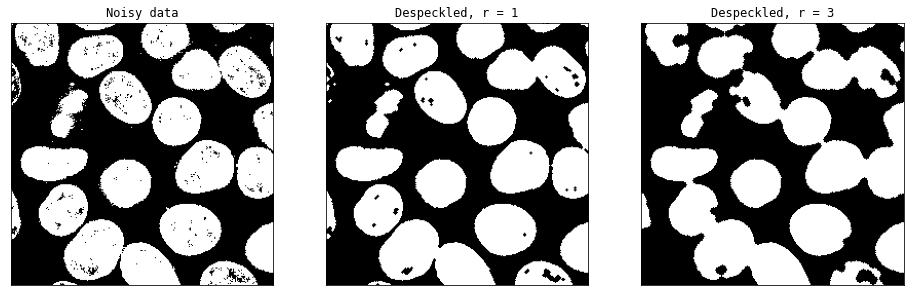

In [27]:
# Create binary image for rescaled image before denoising
plane_binary_rescaled = plane_rescaled >= skimage.filters.threshold_li(plane_rescaled)

# Perform opening then closing to denoise with 2 different radii to compare
plane_despeckled_radius1 = skimage.morphology.closing(
    skimage.morphology.opening(plane_binary_rescaled, selem=skimage.morphology.disk(1)),
    selem=skimage.morphology.disk(1)
)

plane_despeckled_radius3 = skimage.morphology.closing(
    skimage.morphology.opening(plane_binary_rescaled, selem=skimage.morphology.disk(3)),
    selem=skimage.morphology.disk(3)
)

# Plot results
_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

sc.show_plane(win_left, plane_binary_rescaled, title='Noisy data')
sc.show_plane(win_center, plane_despeckled_radius1, title='Despeckled, r = 1')
sc.show_plane(win_right, plane_despeckled_radius3, title='Despeckled, r = 3')

`skiamge.morphology.remove_small_holes` fills holes and `skimage.morphology.remove_small_objects` removes bright regions

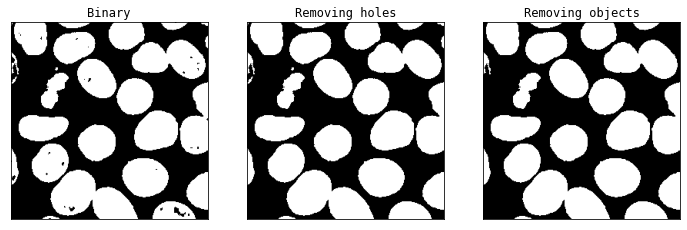

In [28]:
## Remove holes then remove objects and display

# Define hole width
width = 20

# Remove holes
plane_remove_holes = skimage.morphology.remove_small_holes(plane_binary, area_threshold=width ** 2)

# Define minimum object width
width = 50

# Remove objects
plane_remove_objects = skimage.morphology.remove_small_objects(plane_remove_holes, min_size=width)

# Plot results
_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))

sc.show_plane(win_left, plane_binary, title='Binary');
sc.show_plane(win_center, plane_remove_holes, title='Removing holes')
sc.show_plane(win_right, plane_remove_objects, title='Removing objects')

### Measuring image or region properties

[skimage.measure](https://scikit-image.org/docs/stable/api/skimage.measure.html) has multiple algorithms to label images or obtain information about discrete regions of an image
* `measure.label` - Label an image (i.e., identify discrete regions in the image using unique integers)
* `measure.regionprops` - In a labeled image, as returned by label, find various properties of the labeled regions

Finding paths from a 2D image, or isosurfaces from a 3D image.
* `measure.find_contours`
* `measure.marching_cubes_lewiner`
* `measure.marching_cubes_classic`
* `measure.mesh_surface_area` - Surface area of 3D mesh from marching cubes
* `measure.compare_*` - Quantify the difference between two whole images; often used in denoising or restoration

RANdom SAmple Consensus fitting (RANSAC) - a powerful, robust approach to fitting a model to data. It exists here because its initial use was for fitting shapes, but it can also fit transforms.
* `measure.ransac`
* `measure.CircleModel`
* `measure.EllipseModel`
* `measure.LineModelND`

[Image segmentation](https://en.wikipedia.org/wiki/Image_segmentation) partitions images into regions of interest. Integer labels are assigned to each region to distinguish regions of interest.

Connected components of the binary image are assigned the same label via `skimage.measure.label`. Tightly packed cells connected in the binary image are assigned the same label.

In [29]:
import skimage.measure

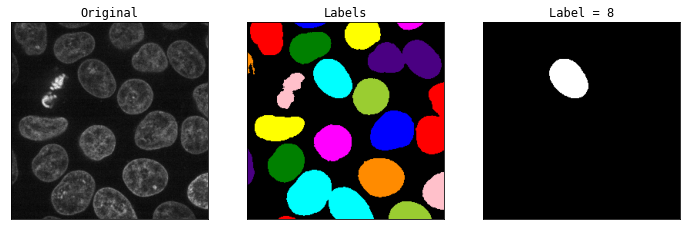

In [39]:
## Label image with holes and objects removed

# Assign labels
plane_labels = skimage.measure.label(plane_remove_objects)

# Plot results
_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sc.show_plane(win_left, plane, title='Original')
#sc.show_plane(win_center, plane_labels, cmap='nipy_spectral', title='Labels')
sc.show_plane(win_center, skimage.color.label2rgb(plane_labels, bg_label=0), title='Labels')
sc.show_plane(win_right, plane_labels == 8, title='Label = 8')

[Watershed segmentation](https://en.wikipedia.org/wiki/Watershed_%28image_processing%29) does an even better job, distinguishing objects that are touching. Markers are placed at local minima and expanded outward until there is a collision with markers from another region. The inverse intensity image transforms bright cell regions into basins which should be filled.

In declumping, markers are generated from the distance function. Points furthest from an edge have the highest intensity and should be identified as markers using `skimage.feature.peak_local_max`. Regions with pinch points should be assigned multiple markers.

The image below shows the distance map. Watershed segmentation is used below after an introduction to the required `skimage.feature` module.

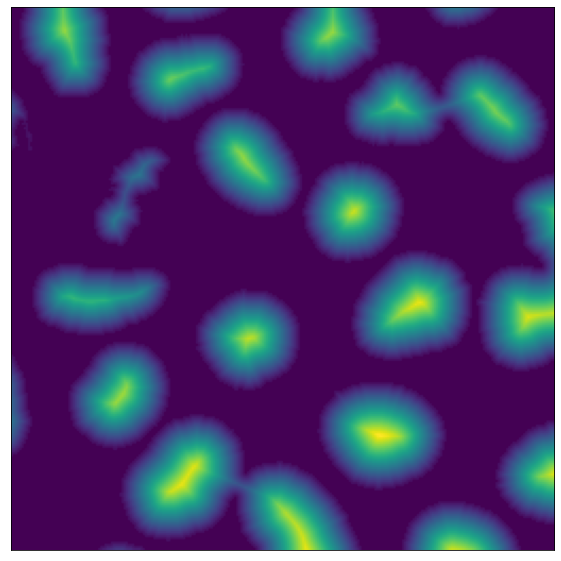

In [31]:
plane_distance = ndimage.distance_transform_edt(plane_remove_objects)

_, win = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sc.show_plane(win, plane_distance, cmap='viridis');

## Extract features from an image

The [`skimage.feature`](https://scikit-image.org/docs/stable/api/skimage.feature.html) submodule presents a diverse set of tools to identify or extract certain features from images, including tools for
* Edge detection: `feature.canny`
* Corner detection:
    * `feature.corner_kitchen_rosenfeld`
    * `feature.corner_harris`
    * `feature.corner_shi_tomasi`
    * `feature.corner_foerstner`
    * `feature.subpix`
    * `feature.corner_moravec`
    * `feature.corner_fast`
    * `feature.corner_orientations`
* Blob detection
    * `feature.blob_dog`
    * `feature.blob_doh`
    * `feature.blob_log`
* Texture
    * `feature.greycomatrix`
    * `feature.greycoprops`
    * `feature.local_binary_pattern`
    * `feature.multiblock_lbp`
* Peak finding: `feature.peak_local_max`
* Object detection
    * `feature.hog`
    * `feature.match_template`
* Stereoscopic depth estimation: `feature.daisy`
* Feature matching
    * `feature.ORB`
    * `feature.BRIEF`
    * `feature.CENSURE`
    * `feature.match_descriptors`
    * `feature.plot_matches`

In [32]:
import skimage.feature

We are going to use the `skimage.feature.peak_local_max` function when performing watershed segmentation, below.

## Identifying regions of interest

One of the key image analysis tasks is identifying regions of interest. These could be a person, an object, certain features of an animal, microscopic image, or stars. Segmenting an image is the process of determining where these things you want are in your images. This is done in the [`skimage.segmentation`](https://scikit-image.org/docs/stable/api/skimage.segmentation.html) module.

Segmentation has two overarching categories:

__Supervised__ - must provide some guidance (seed points or initial conditions)
* `segmentation.random_walker`
* `segmentation.active_contour`
* `segmentation.watershed`
* `segmentation.flood_fill`
* `segmentation.flood`

__Unsupervised__ - no human input
* `segmentation.slic`
* `segmentation.felzenszwalb`
* `segmentation.chan_vese`

There are also some supervised and unsupervised thresholding algorithms in `filters`. There is a [segmentation lecture](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/4_segmentation.ipynb) ([and its solution](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/4_segmentation.ipynb)) you may peruse, as well as many [gallery examples](https://scikit-image.org/docs/stable/auto_examples/index.html#segmentation-of-objects) which illustrate all of these segmentation methods.

In [49]:
import skimage.segmentation

Now, we will illustrate the watershed segmentation discussed above.

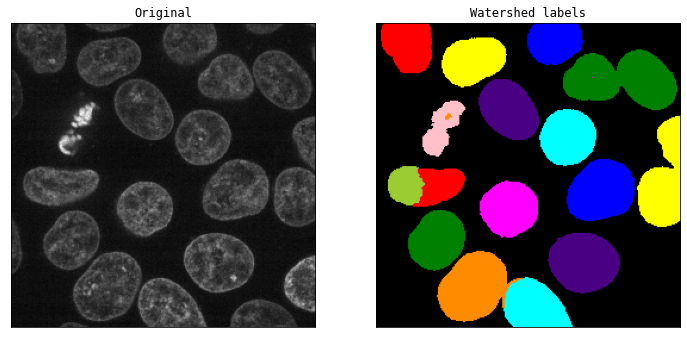

In [50]:
## Use watershed segmentation to distinguish touching objects

# Find local maxima from the distance-from-edge map of the objects
peak_local_max = skimage.feature.peak_local_max(
    plane_distance, # Look for peaks in the distance-from-edge map
    footprint=np.ones((15, 15), dtype=np.bool), # Local region to search for peaks at every point
    indices=False, # Don't output indices of peaks
    labels=skimage.measure.label(plane_remove_objects) # Define unique regions to search for peaks
)

# Mark each of the unique peaks
plane_markers = skimage.measure.label(peak_local_max)

# Use watershed segmentation to label different objects
plane_labels = skimage.segmentation.watershed(
    plane_rescaled, 
    plane_markers, 
    mask=plane_remove_objects
)

# Plot the results
_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

sc.show_plane(win_left, plane, title='Original')
#sc.show_plane(win_right, plane_labels, cmap='nipy_spectral', title='Watershed labels')
sc.show_plane(win_right, skimage.color.label2rgb(plane_labels, bg_label=0), title='Watershed labels')

The watershed algorithm falsely detected subregions within some of the cells. This is called oversegmentation.

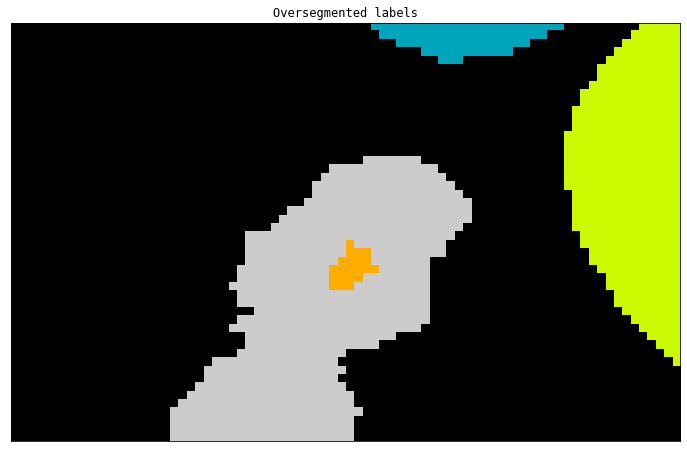

In [51]:
# Plot a portion of one of the cells to visualize oversegmentation
_, axis = plt.subplots(figsize=(12, 8))
sc.show_plane(axis,
              plane_labels[50:100, 20:100],
              cmap='nipy_spectral',
              title='Oversegmented labels')

Plotting the markers on the distance image reveals the reason for oversegmentation. Cells with multiple markers will be assigned multiple labels, and oversegmented. It can be observed that cells with a uniformly increasing distance map are assigned a single marker near their center. Cells with uneven distance maps are assigned multiple markers, indicating the presence of multiple local maxima.

[]

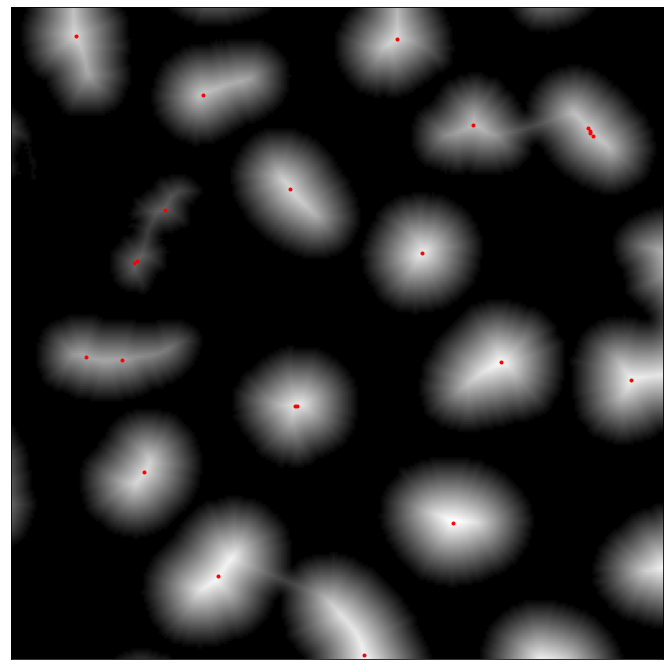

In [52]:
## Plot the locations of the peaks on top of the distance-to-edge map

# Get subplot
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 12))

# Plot the distance-to-edge map
ax.imshow(plane_distance, cmap='gray')
    
# Find the non-zero points in the peak_local_max array
# i.e., the peaks
peaks = np.nonzero(peak_local_max)
    
# Plot the peal coordinates as red dots    
ax.plot(peaks[1], peaks[0], 'r.')
ax.set_xticks([])
ax.set_yticks([])

We could improve the feature selection process by blurring the input data, using a larger footprint in `peak_local_max`, etc.

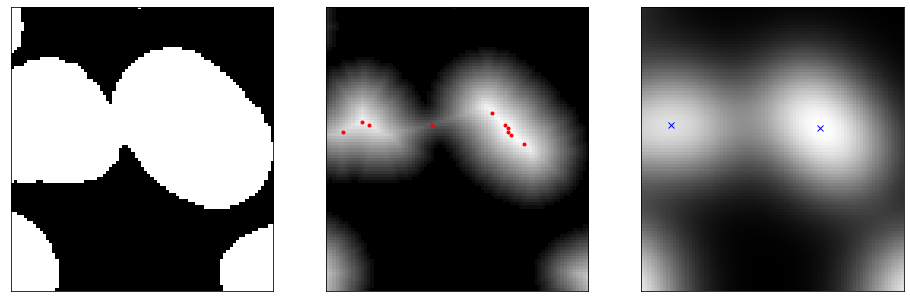

In [53]:
## Compare the peak detection on smoothed and unsmoothed distance-to-edge maps

# Get subplot locations
_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

# Display the selected part of the objects mask 
sc.show_plane(win_left, plane_remove_objects[10:100, 170:253])

# Display the selected park of the distance-to-edge map
sc.show_plane(win_center, plane_distance[10:100, 170:253])

# Find and display the peaks using the unsmoothed distance-to-edge map
features = skimage.feature.peak_local_max(plane_distance[10:100, 170:253])
win_center.plot(features[:, 1], features[:, 0], 'r.')

# Smooth the distance-to-edge map and display
smooth_distance = skimage.filters.gaussian(plane_distance[10:100, 170:253], sigma=10)
sc.show_plane(win_right, smooth_distance)

# Then find and display the peaks from the smoothed map
features = skimage.feature.peak_local_max(smooth_distance)
win_right.plot(features[:, 1], features[:, 0], 'bx')

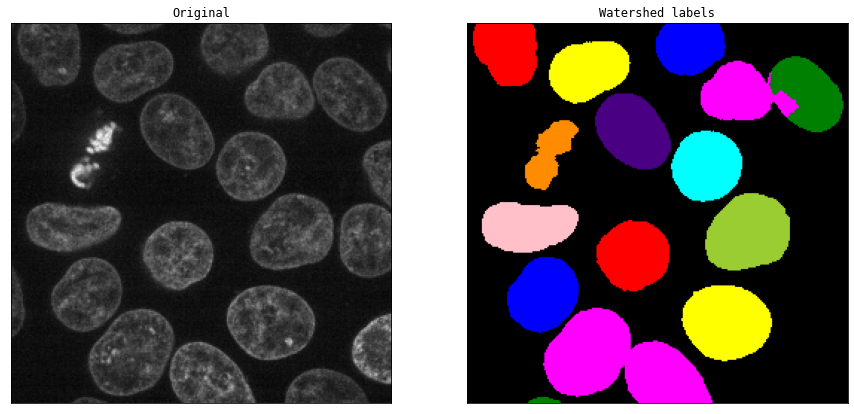

In [54]:
## Use the smoothed distance-to-edge map to find the watershed labels

# Smooth the entire distance-to-edge map
smooth_distance = skimage.filters.gaussian(plane_distance, sigma=10)

# Calculate the local maxima in the same way as before
# but now using the smoothed distance-to-edge map
peak_local_max = skimage.feature.peak_local_max(
    smooth_distance,
    footprint=np.ones((15, 15), dtype=np.bool),
    indices=False,
    labels=skimage.measure.label(plane_remove_objects)
)

# Mark the calculated local maxima
plane_markers = skimage.measure.label(peak_local_max)

# Label the objects using watershed segmentation
plane_labels = skimage.segmentation.watershed(
    plane_rescaled, 
    plane_markers, 
    mask=plane_remove_objects
)

# Plot the results
_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

sc.show_plane(win_left, plane, title='Original')
#sc.show_plane(win_right, plane_labels, cmap='nipy_spectral', title='Watershed labels')
sc.show_plane(win_right, skimage.color.label2rgb(plane_labels, bg_label=0), title='Watershed labels')

### Exercise

Look at the results of watershed segmentation when the `median` filter is applied instead of `gaussian`

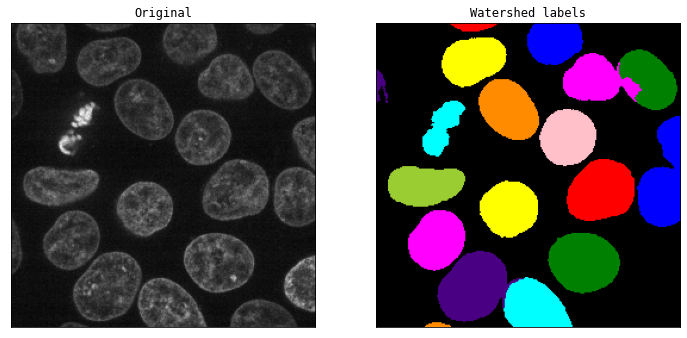

In [60]:
## Use watershed segmentation to identify objects after
## using the median filter to smooth the distance-to-edge map

# Smooth distance-to-edge map using median filter
smooth_distance = skimage.filters.median(
    plane_distance, 
    selem=skimage.morphology.disk(20), 
    behavior='ndimage'
)

# Find the local maxima
peak_local_max = skimage.feature.peak_local_max(
    smooth_distance,
    footprint=np.ones((15, 15), dtype=np.bool),
    indices=False,
    labels=skimage.measure.label(plane_remove_objects)
)

# Mark the different maxima
plane_markers = skimage.measure.label(peak_local_max)

# Use watershed segmentation to label the different objects
plane_labels = skimage.segmentation.watershed(
    plane_rescaled, 
    plane_markers, 
    mask=plane_remove_objects
)

# Plot the results
_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

sc.show_plane(win_left, plane, title='Original')
#sc.show_plane(win_right, plane_labels, cmap='nipy_spectral', title='Watershed labels')
sc.show_plane(win_right, skimage.color.label2rgb(plane_labels, bg_label=0), title='Watershed labels')

[Feature extraction](https://en.wikipedia.org/wiki/Feature_extraction) reduces data required to describe an image or objects by measuring informative features. These include features such as area or volume, bounding boxes, and intensity statistics.

Before measuring objects, it helps to clear objects from the image border. Measurements should only be collected for objects entirely contained in the image.

Interior labels: [ 0  3  4  5  7  8  9 10 11 13 14 15 16]


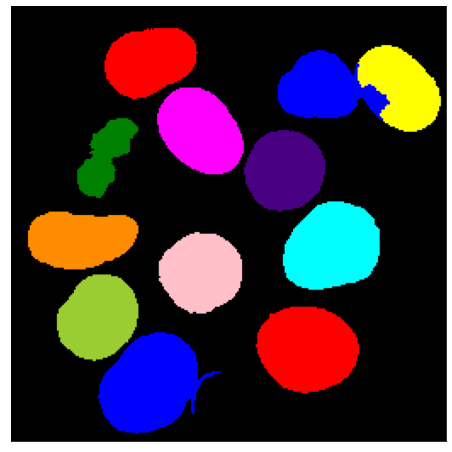

In [63]:
## Remove objects that are not completely contained within the image

# Remove object on border
plane_labels_inner = skimage.segmentation.clear_border(plane_labels)

# Remove small objects
plane_labels_inner = skimage.morphology.remove_small_objects(plane_labels_inner, min_size=200)

# Find the labels for the remaining objects
print('Interior labels: {}'.format(np.unique(plane_labels_inner)))

# Plot the remaining objects
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
#sc.show_plane(axis, plane_labels_inner, cmap='nipy_spectral')
sc.show_plane(axis, skimage.color.label2rgb(plane_labels_inner, bg_label=0))

After clearing the border, the object labels are no longer sequentially increasing. The labels can be renumbered such that there are no jumps in the list of image labels:

In [66]:
# Relabel remaining objects
plane_relabeled, _, _ = skimage.segmentation.relabel_sequential(plane_labels_inner)

print('Relabeled labels: {}'.format(np.unique(plane_relabeled)))

Relabeled labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


## Measuring object properties 

`skimage.measure.regionprops` automatically measures many labeled image features. Optionally, an `intensity_image` can be supplied and intensity features are extracted per object. It's good practice to make measurements on the original image.

The list below shows supported 2D measurements.

In [67]:
## Get a list of the supported 2D measurements in measure.regionprops
properties = skimage.measure.regionprops(plane_relabeled, intensity_image=plane)
props_first_region = properties[0]

supported = [''] 

for prop in props_first_region:
    try:
        props_first_region[prop]
        supported.append(prop)
    except NotImplementedError:
        pass

print('Supported 2D properties:')
print('\n\t'.join(supported))

Supported 2D properties:

	area
	bbox
	bbox_area
	centroid
	convex_area
	convex_image
	coords
	eccentricity
	equivalent_diameter
	euler_number
	extent
	filled_area
	filled_image
	image
	inertia_tensor
	inertia_tensor_eigvals
	intensity_image
	label
	local_centroid
	major_axis_length
	max_intensity
	mean_intensity
	min_intensity
	minor_axis_length
	moments
	moments_central
	moments_hu
	moments_normalized
	orientation
	perimeter
	slice
	solidity
	weighted_centroid
	weighted_local_centroid
	weighted_moments
	weighted_moments_central
	weighted_moments_hu
	weighted_moments_normalized


`skimage.measure.regionprops` ignores the 0 label, which represents the background.

In [68]:
print('Measured regions: {}'.format([prop.label for prop in properties]))

Measured regions: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [70]:
## Select and display the areas for the different objects
## from the properties
cells_areas = [prop.area for prop in properties]

print('Total pixels: {}'.format(cells_areas))

Total pixels: [1717, 1698, 1618, 1914, 887, 1776, 1753, 2320, 1795, 1837, 2381, 2660]


Collected measurements can be further reduced by computing per-image statistics such as total, minimum, maximum, mean, and standard deviation.

In [71]:
print('Area statistics\n')
print(' * Total: {}'.format(np.sum(cells_areas)))
print(' * Min: {}'.format(np.min(cells_areas)))
print(' * Max: {}'.format(np.max(cells_areas)))
print(' * Mean: {:0.2f}'.format(np.mean(cells_areas)))
print(' * Standard deviation: {:0.2f}'.format(np.std(cells_areas)))

Area statistics

 * Total: 22356
 * Min: 887
 * Max: 2660
 * Mean: 1863.00
 * Standard deviation: 428.28


### Exercise

Check some of the other properties for the labeled regions

In [72]:
cells_conv_areas = [prop.convex_area for prop in properties]
cells_orientation = [prop.orientation for prop in properties]

print('Convex areas: {}'.format(cells_conv_areas))
print('Orientation: {}'.format(cells_orientation))

Convex areas: [1754, 2027, 1784, 1942, 1033, 1811, 1820, 2360, 1833, 1871, 2429, 2981]
Orientation: [-1.2422396138051446, 1.4275835784540836, 0.6716373531981716, 0.7444551176840744, -0.49640417339472537, -0.7072115549148924, -1.5179905444173007, -1.0526754424954612, -1.3248305665259055, -0.6191811867434878, 1.3939882686315603, -0.8352648718811038]


## Going beyond

\[1\] A tour/guide on scikit-image's submodules: https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/tour_of_skimage.ipynb

\[2\] scikit-image's gallery examples: https://scikit-image.org/docs/stable/auto_examples/